In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2
from scipy.interpolate import interpn
from scipy.signal import convolve2d
from tqdm import tqdm

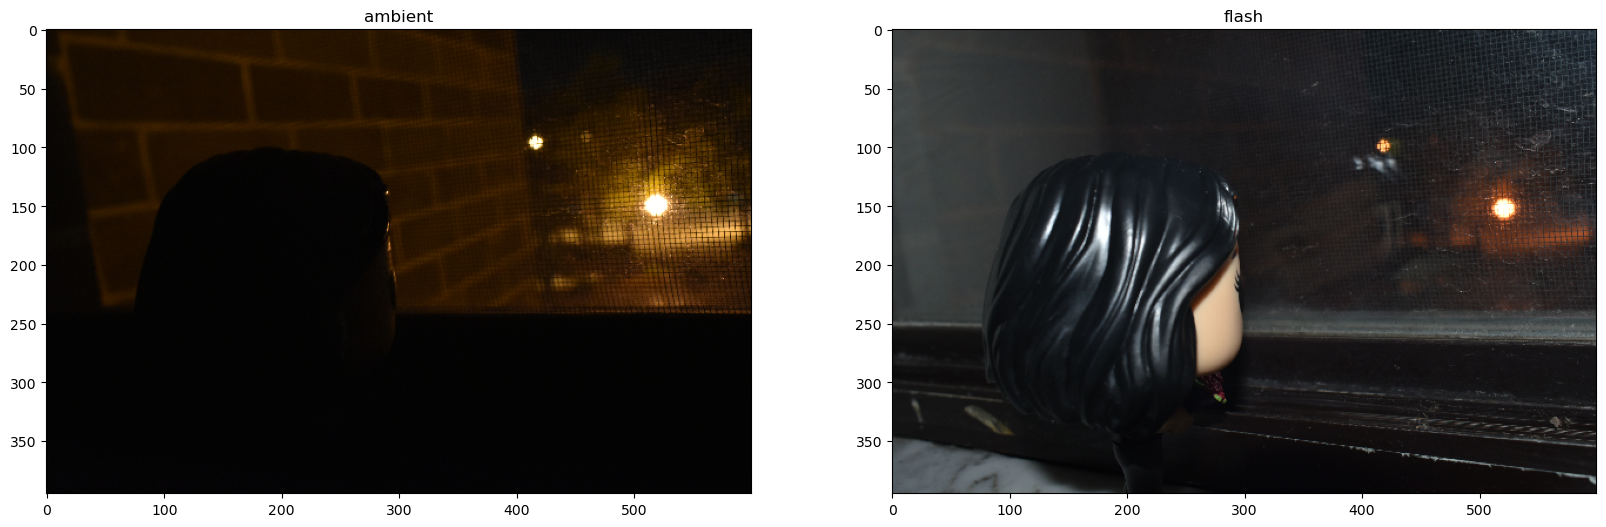

In [96]:
img_fanko_amb = './data/my_img/reflection_amb.jpg'
img_fanko_flash = './data/my_img/reflection_flash.jpg'

skip = 1
img_fanko_amb = cv2.imread(img_fanko_amb,-1)[::skip,::skip,:3][:-50,:,::-1]
img_fanko_flash = cv2.imread(img_fanko_flash,-1)[::skip,::skip,:3][:-50,:,::-1]

# too high resolution. resize
img_fanko_amb = cv2.resize(img_fanko_amb, (0,0), fx=0.1, fy=0.1)
img_fanko_flash = cv2.resize(img_fanko_flash, (0,0), fx=0.1, fy=0.1)

img_fanko_amb_norm = img_fanko_amb / 255
img_fanko_flash_norm = img_fanko_flash / 255

# H = img_fanko_amb_norm*2/4  + img_fanko_flash_norm*3/4

H = img_fanko_amb_norm*1/4  + img_fanko_flash_norm*3/4
H = H / np.max(H)

plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
plt.title('ambient')
plt.imshow(img_fanko_amb_norm)

plt.subplot(1,2,2)
plt.title('flash')
plt.imshow(img_fanko_flash_norm)


In [83]:
def compute_gradient(img) : 

    # pad image with zeros    
    temp = img[:,:]
    
    row = np.zeros((1,img.shape[1]))
    col = np.zeros((img.shape[0]+2,1))
    
    temp2 = np.vstack((row,np.vstack((temp, row))))
    temp2 = np.hstack((col,np.hstack((temp2, col))))
    img = temp2 

    img_x = np.diff(img,n=1,axis=1) 
    img_y = np.diff(img,n=1,axis=0)  

    return img_x, img_y

def compute_laplacian(img) :     
    
    # laplacian kernel
    kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    
    out = convolve2d(img, kernel, mode='same', boundary='fill', fillvalue=0)
    
    return out 

channel = 2

def compute_div(u,v) :
    u_x = np.diff(u,n=1,axis=1)
    v_y = np.diff(v,n=1,axis=0)
    u_x, v_y = u_x[1:-1,:], v_y[:,1:-1]
    
    out = u_x + v_y
    
    return out


In [84]:
def CGD(I_init, B, I_star_boundary, eps, N, D) :
    """
    Perform conjugate gradient descent to solve Poisson's equation.
    """
    
    I_star = B * I_init + (1-B) * I_star_boundary
    r = B * (D - compute_laplacian(I_star))
    d = r 
    delta_new = np.sum(r*r) # <r,r>
    
    n = 0
    while np.sqrt(np.sum(r*r)) > eps and n < N :
        
        q = compute_laplacian(d)
        eta = delta_new / np.sum(d*q)
        
        I_star = I_star + B * (eta * d)
        r = B * (r - eta * q)
        
        delta_old = delta_new.copy()
        delta_new = np.sum(r*r)
        
        beta = delta_new / delta_old 
        d = r + beta * d   
    
        n = n + 1
    
    print("Number of iterations = ",n)
    print("Final error = ",np.sqrt(np.sum(r*r)))
    
    return I_star

def poisson_solver(lap_img, img, N = 1000, eps = 0.001) :
    """
    Solve Poisson's equation using conjugate gradient descent.
    """
    
    I_init = np.zeros(img.shape)
    
    boundary_size = 1
    B = np.ones(img.shape)
    B[0:boundary_size,:], B[-boundary_size:-1,:], B[:,0:boundary_size], B[:,-boundary_size:-1] = 0,0,0,0
    
    I_star_boundary = np.zeros(img.shape)
    I_star_boundary[0:boundary_size,:] = img[0:boundary_size,:]
    I_star_boundary[-boundary_size:-1,:] = img[-boundary_size:-1,:]
    I_star_boundary[:,0:boundary_size] = img[:,0:boundary_size]
    I_star_boundary[:,-boundary_size:-1] = img[:,-boundary_size:-1]
    
    I_star = CGD(I_init, B, I_star_boundary, eps, N, lap_img) 
    
    return I_star

In [76]:
# Compute Laplacian for each color channel
lap_img = np.zeros_like(H)
for channel in range(3) :
    lap_img[:,:,channel] = compute_laplacian(H[:,:,channel])

# Solve Poisson's equation for each color channel
I_star = np.zeros_like(H)
for channel in range(3) :
    I_star[:,:,channel] = poisson_solver(lap_img[:,:,channel], H[:,:,channel])


Number of iterations =  766
Final error =  0.000999205389572816
Number of iterations =  701
Final error =  0.0009896774235332436
Number of iterations =  697
Final error =  0.0009917529972963842


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'I_star')

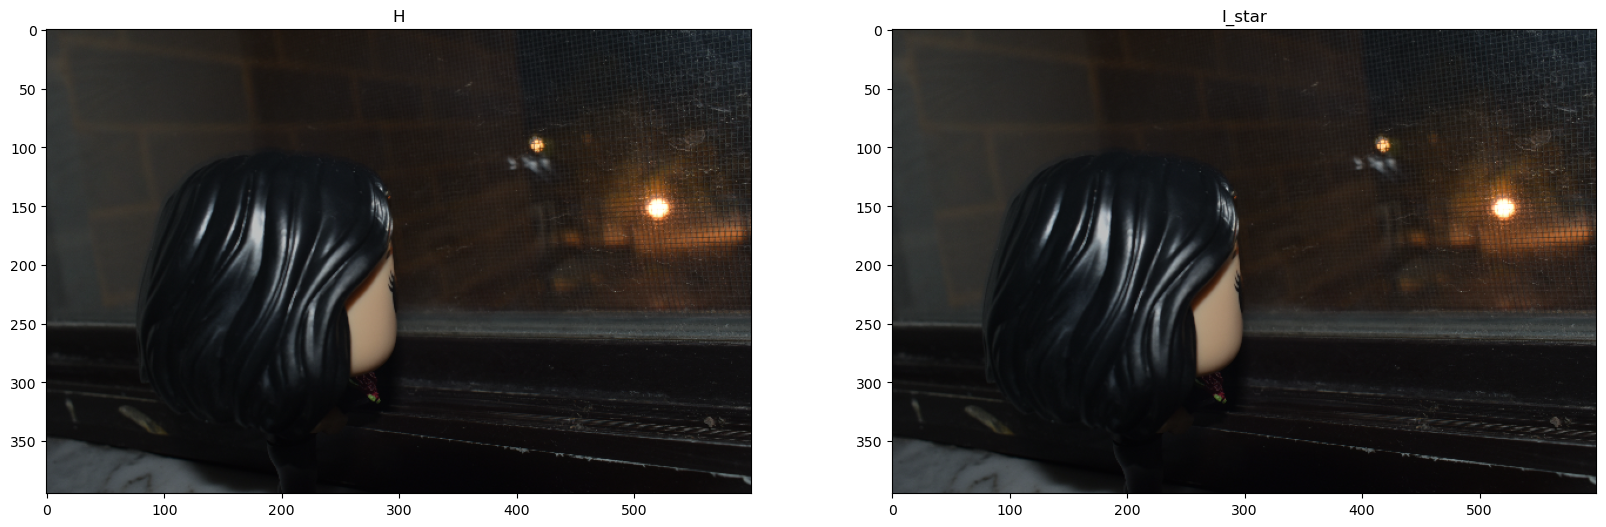

In [77]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(H)
plt.title('H')

plt.subplot(1,2,2)
plt.imshow(I_star)
plt.title('I_star')


Number of iterations =  972
Final error =  9.985400793211944e-05
Number of iterations =  914
Final error =  9.986652720265365e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of iterations =  1017
Final error =  9.859194723794865e-05


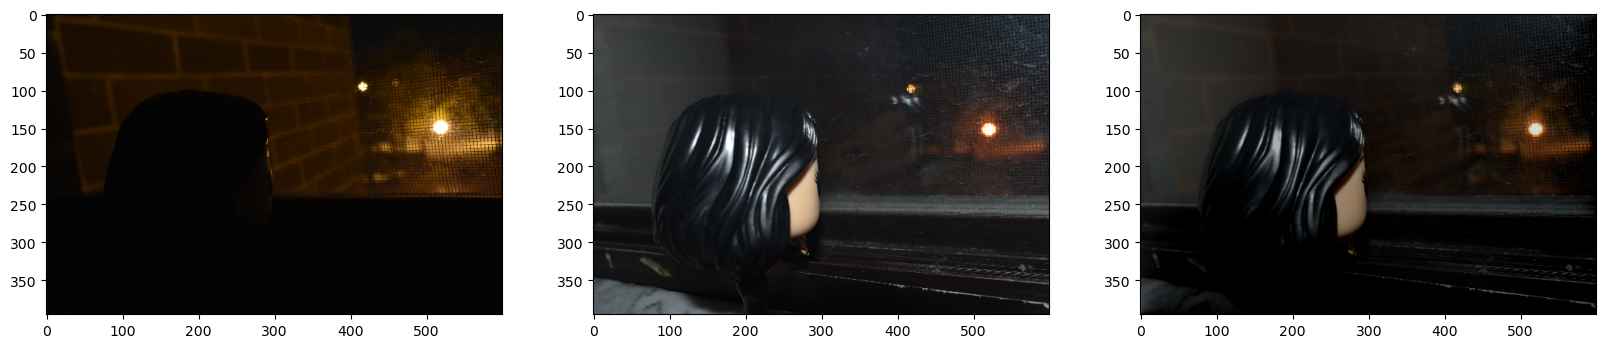

In [94]:
# Gradient fuse for removing reflections

def div_phi_star_remove_refl(img_amb_norm, img_flash_norm, H): 
    
    a_x, a_y = compute_gradient(img_amb_norm)
    phi_dash_x, phi_dash_y = compute_gradient(img_flash_norm)
    h_x, h_y = compute_gradient(H)
    
    a_x_org = a_x.copy()
    a_y_org = a_y.copy()
    
    a_x, phi_dash_x, h_x = a_x[1:,:], phi_dash_x[1:,:], h_x[1:,:]
    a_y, phi_dash_y, h_y = a_y[:,1:], phi_dash_y[:,1:], h_y[:,1:]
    
    h_proj_alpha = lambda h_grad,a_grad : a_grad * (h_grad * a_grad) / np.sqrt(np.sum(a_grad**2))  
    
    sigma = 0.1
    # sigma = 40

    tau_ue = 0.1
    w_ue = np.zeros(a_x.shape)
    w_ue[:-1,:-1] = 1 - np.tanh(sigma * (img_flash_norm-tau_ue))
    w_ue = (w_ue - np.min(w_ue)) / (np.max(w_ue) - np.min(w_ue))
    
    # wue = 1
    phi_star_x = np.zeros(a_x_org.shape)
    phi_star_y = np.zeros(a_y_org.shape)
    phi_star_x[1:,:] = w_ue * h_x + (1-w_ue) * (h_proj_alpha(h_x, a_x))
    phi_star_y[:,1:] = w_ue * h_y + (1-w_ue) * (h_proj_alpha(h_y, a_y))
    
    div = compute_div(phi_star_x, phi_star_y)
    
    return div
    
div_phi_star = np.zeros_like(img_fanko_amb_norm)
for channel in range(3) :
    div_phi_star[:,:,channel] = div_phi_star_remove_refl(img_fanko_amb_norm[:,:,channel], img_fanko_flash_norm[:,:,channel], H[:,:,channel])

I_star = np.zeros_like(img_fanko_amb_norm)
for channel in range(3) :
    I_star[:,:,channel] = poisson_solver(div_phi_star[:,:,channel], H[:,:,channel], N=5000, eps=0.0001) 



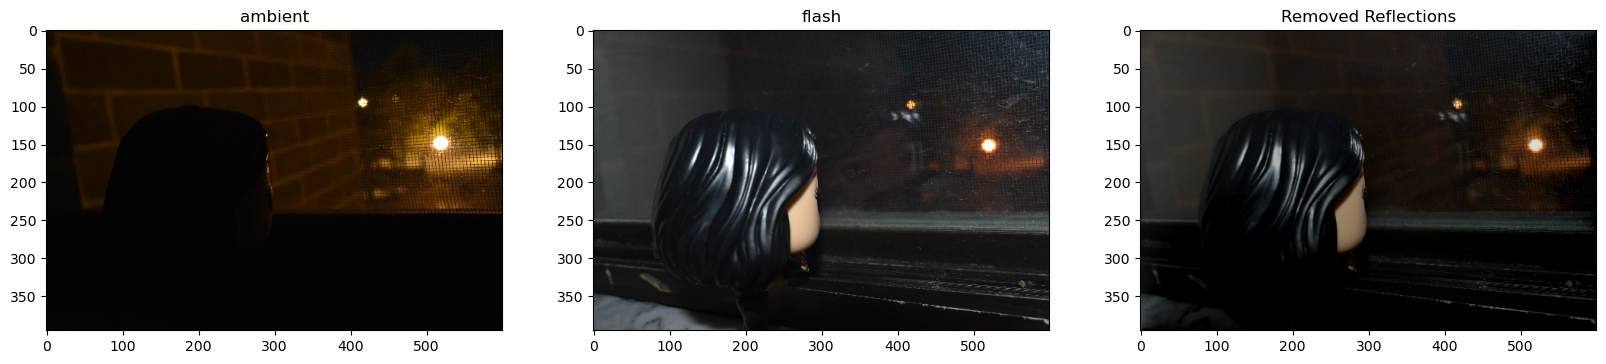

In [97]:
fig, ax = plt.subplots(3, figsize = (20,20))

plt.subplot(1,3,1)
plt.imshow(img_fanko_amb_norm)
plt.title('ambient')

plt.subplot(1,3,2)
plt.imshow(img_fanko_flash_norm)
plt.title('flash')

plt.subplot(1,3,3)
plt.imshow(np.clip(I_star,0,1))
plt.title('Removed Reflections')

plt.show()

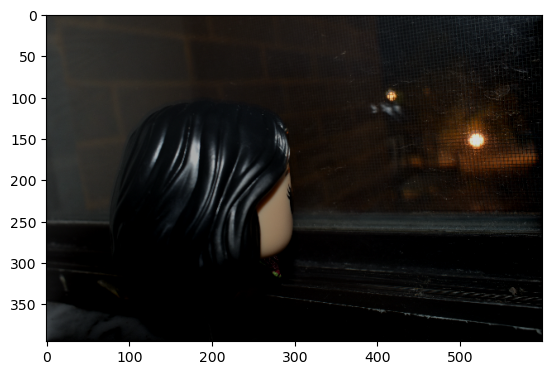

In [98]:
plt.imshow(np.clip(I_star,0,1))

In [99]:
plt.imsave('./outputs/I_star_removerflect.png', np.clip(I_star,0,1))